# study03-1で生成したcsvファイルを読み込み、グラフ化する。
  - csvファイルをDataFrameに読みこむ。
  - DataFrame内にはYear、Regionフィールドがあり値が重複している。***groupbyでMultiIndex DataFrame***を作り処理をする。その際、他のフィールドは平均値としておく。
  - 先に作った***MultiIndex DataFrameのlevelを指定して部分的にDataFrameを取得してイテレーション***し、処理をする。
  - ***matplotlib.pyplot***を用いてグラフ化。***折れ線グラフ***を生成する。

---
## 1.  csvファイルを読み込む

In [1]:
import numpy as np
import glob
import pandas as pd
csv_JH = '.\\Data\\03_Sample\\JH.csv'

In [2]:
df_JH = pd.read_csv(csv_JH, encoding='Shift_JISx0213')
display(df_JH.head(5))

,Region,Year,Koku,Su
0,1,2007,81.683626,71.984765
1,2,2007,82.510161,73.106976
2,3,2007,81.752606,71.858818
3,4,2007,81.429095,71.106606
4,1,2008,73.745387,63.687490


---
## 2. Year、Region毎にグルーピングし、グループごとにイテレーションをする。
### 2-1.  MultiIndex DataFrameを生成
  - Yearは2007～2019がある。途中抜けた年がある。
  - Regionは4種類(1,2,3,4)
  - 2種類以上のフィールドでgroupbyをした場合に出来があるDataFrameをMultiIndex DataFrameというようで、引数に渡した順番で左からlevel=0、level=1とindexにレベル付けが行われる。
  - 以下の場合、Yearはlevel=0、Regionはlevel=1となる。

In [3]:
df_JH_grp = df_JH.groupby(['Year','Region']).mean()
display(df_JH_grp.head(5))

Koku         Su
Year Region                      
2007 1       81.683626  71.984765
     2       82.510161  73.106976
     3       81.752606  71.858818
     4       81.429095  71.106606
2008 1       73.745387  63.687490

## 2-2. MultiIndex DataFrameをグループごとにイテレーションしてみる。
  - level=0、Yearでイテレーション。idxにはYearの値が入り、df_selectには、Year毎のDataFrameの塊が入る。
  - level=1でイテレーションした場合、idxにはRegionの値が入り、df_selectにはRegion毎のDataFrameの塊が入る。

In [4]:
for idx, df_select in df_JH_grp.groupby(level=[0]):
    print('------------')
    display(idx)
    display(df_select)
    if idx == 2008:
        break

------------


2007

Koku         Su
Year Region                      
2007 1       81.683626  71.984765
     2       82.510161  73.106976
     3       81.752606  71.858818
     4       81.429095  71.106606

------------


2008

Koku         Su
Year Region                      
2008 1       73.745387  63.687490
     2       73.959331  64.141464
     3       73.672881  62.998008
     4       73.423445  61.742351

## 2-3. イテレーション結果をグラフ化

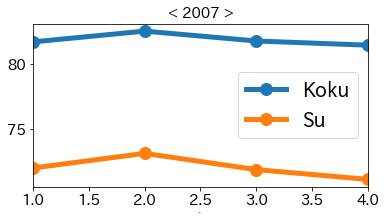

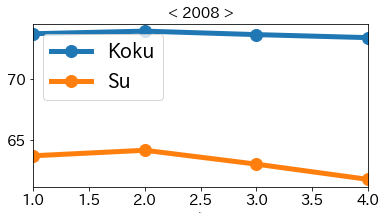

In [6]:
import matplotlib.pyplot as plot

for idx, df_select in df_JH_grp.groupby(level=[0]):
    # X軸にRegionの値をとりたいので、index（level=0、Year）を解き、Regionをindexに設定する。
    tmp = df_select.reset_index()
    tmp = tmp.set_index('Region')
    
    # Yearフィールドは不要なので削除
    tmp = tmp.drop('Year', axis=1)
    
    params = {
        'axes.titlesize': 15,
        'axes.labelsize': -1,
        'legend.fontsize': 20,
        'figure.figsize': (6, 3),
        'lines.linewidth' : 5.0,
        'lines.markersize' : 12,
        'lines.marker':'o',
        'xtick.labelsize' : 15,
        'ytick.labelsize' : 15
    }
    plot.rcParams.update(params)
   
    tmp.plot(kind='line', stacked=False,  title = "< "+ str(idx) + " >", \
             markevery = 1 )
    
    if idx == 2008:
        break

---
## 3. Year、Region毎にグルーピングし、グループごとにイテレーションして処理をする。

## 3-1. Year毎にDataFrameを取り出し、Koku、SuそれぞれRegion=1の値を用いて標準化する。

In [7]:
df_JH_norm = pd.DataFrame()

for idx, df_select in df_JH_grp.groupby(level=[0]):
    # これが無いとうまくいかない
    df_select = df_select.copy()

    # Retion=1の値を取得
    # k = df_select['Koku'][0]
    # s = df_select['Su'][0]

    # Retion=1の値を取得 2
    # 上記の方法でも取れるが、indexを指定して取得すると以下になる。
    # ただし、そのままでは使えないため、処理が必要。
    k_tmp = df_select.loc[(idx,1), ['Koku']]
    s_tmp = df_select.loc[(idx,1), ['Su']]
    # display(k_tmp)
    # display(k_tmp.Koku)
    k = k_tmp.Koku
    s = s_tmp.Su

    # 標準化
    df_select['Koku'] = df_select['Koku'] / k
    df_select['Su'] = df_select['Su'] / s

    # 処理結果を保持
    df_JH_norm = df_JH_norm.append(df_select)
    
display(df_JH_norm.head(5))

Koku        Su
Year Region                    
2007 1       1.000000  1.000000
     2       1.010119  1.015590
     3       1.000844  0.998250
     4       0.996884  0.987801
2008 1       1.000000  1.000000

## 3-2. 処理結果をグラフ化

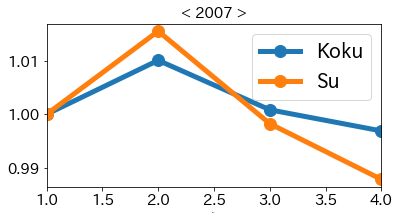

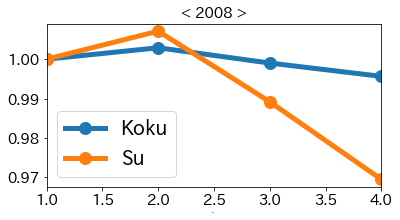

In [8]:
import matplotlib.pyplot as plot

for idx, df_select in df_JH_norm.groupby(level=[0]):
    # X軸にRegionの値をとりたいので、index（level=0、Year）を解き、Regionをindexに設定する。
    tmp = df_select.reset_index()
    tmp = tmp.set_index('Region')
    
    # Yearフィールドは不要なので削除
    tmp = tmp.drop('Year', axis=1)
    
    params = {
        'axes.titlesize': 15,
        'axes.labelsize': -1,
        'legend.fontsize': 20,
        'figure.figsize': (6, 3),
        'lines.linewidth' : 5.0,
        'lines.markersize' : 12,
        'lines.marker':'o',
        'xtick.labelsize' : 15,
        'ytick.labelsize' : 15
    }
    plot.rcParams.update(params)
   
    tmp.plot(kind='line', stacked=False,  title = "< "+ str(idx) + " >", \
             markevery = 1 )
    
    if idx == 2008:
        break